## IMPORTOWANIE BIBLIOTEK I WCZYTANIE DANYCH

In [1]:
# Importy systemowe
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Dodanie ścieżki do modułów projektu
sys.path.append('src')

# Importy z własnych modułów
from data_processing import load_data, clean_data, select_features
from feature_engineering import transform_to_binary, analyze_categorical_variables, extract_xy, calculate_angles_distances, transform_body_part, analyze_freeze_frame, standardize_features, create_dummies, calculate_vif
from models import prepare_train_test_split, train_logistic_regression, train_random_forest, train_xgboost
from evaluation import evaluate_model
from visualization import create_quantile_efficiency, plot_shot_accuracy_by_distance_and_y, visualize_shot_situation, plot_binary_features_comparison, plot_stacked_bar, plot_body_part_by_distance_quantile, plot_shot_success_heatmap, plot_shot_effectiveness_by_quantiles, plot_angle_distribution, plot_roc_curve, plot_expected_vs_actual_goals, plot_reliability_diagram

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV


# Ścieżka do danych
DATA_DIR = os.path.join(os.getcwd(), 'data')
DATA_PATH = os.path.join(DATA_DIR, 'all_shots_combined_2015_2016.csv')

In [2]:
df = load_data(DATA_PATH)

Wczytano dane: (45719, 120)


Wczytany zbiór danych jest mocno rozbudowany. Zawiera **45 719 obserwacji** oraz **120 zmiennych**. Jednak nie wszystkie zmienne są powiązane ze strzałami. W związku z tym już teraz mogę usunąć zmienne, które dla wszystkich obserwacji przyjmują wartość NaN.

In [3]:
df_cleaned = clean_data(df)

Usunięto 80 kolumn z samymi NaN
Nowy wymiar danych: (45719, 40)
Pozostało 40 kolumn:
- duration
- id
- index
- location
- match_id
- minute
- off_camera
- out
- period
- play_pattern
- player
- player_id
- position
- possession
- possession_team
- possession_team_id
- related_events
- second
- shot_aerial_won
- shot_body_part
- shot_deflected
- shot_end_location
- shot_first_time
- shot_follows_dribble
- shot_freeze_frame
- shot_key_pass_id
- shot_one_on_one
- shot_open_goal
- shot_outcome
- shot_redirect
- shot_saved_off_target
- shot_saved_to_post
- shot_statsbomb_xg
- shot_technique
- shot_type
- team
- team_id
- timestamp
- type
- under_pressure


W wyniku tej operacji rozmiar zbioru zmniejszył się do **40 kolumn**. Po przejrzeniu pozostałych zmiennych udało mi się wybrać te potencjalnie istotne dla przyszłego modelu.

## WSTĘPNY ZBIÓR DANYCH BEZ OBRÓBKI ZMIENNYCH

In [4]:
features = [
    'shot_outcome', # zmienna objaśniana
    'under_pressure', 'location', 
    'shot_technique', 'shot_body_part',
    'shot_type', 'shot_first_time', 'shot_open_goal',
    'shot_one_on_one', 'shot_follows_dribble', 'shot_freeze_frame',
    'player_id', # do transformacji shot_body_part
]

df_shots = select_features(df_cleaned, features)

Wybrano 12 cech
Nowy wymiar danych: (45719, 12)


Do dalszej obróbki wybrałem następujące zmienne:
- **shot_outcome** - przyszła zmienna objaśniana opisująca rezultat oddanego strzału,
- **under_pressure** - zmienna binarna; czy strzał był oddawany pod presją przeciwnika,
- **location** - zmienna informująca o lokalizacji, z której oddano strzał; koordynaty x (0-120) oraz y (0-80),
- **shot_technique** - zmienna kategorialna; technika oddania strzału,
- **shot_body_part** - zmienna kategorialna; część ciała którą oddano strzał,
- **shot_type** - zmienna kategorialna; w jakiej sytuacji oddano strzał: "z gry", z rzutu wolnego, z rzutu karnego, itp.
- **shot_first_time** - zmienna binarna; czy strzał był odddany z pierwszej piłki (bez przyjęcia),
- **shot_open_goal** - zmienna binarna; czy strzał był odddany "do pustej bramki",
- **shot_one_to_one** - zmienna binarna; czy strzał był odddany w wyniku sytuacji "jeden na jednego",
- **shot_follows_dribble** - zmienna binarna; czy strzał był odddany po dryblingu,
- **shot_freeze_frame** - zmienna zawierająca lokalizacje innych zawodników w momencie oddania strzału;
- **player_id** - zmienna pomocnicza; numer identyfikacyjny piłkarza.

## TRANSFORMACJA ZMIENNEJ OBJAŚNIANEJ W ZMIENNĄ BINARNĄ

Pierwszym krokiem po zdefiniowaniu zbioru danych było utworzenie zmiennej docelowej poprzez transformację zmiennej *shot_outcome* w zmienną binarną.

In [5]:
df_shots = transform_to_binary(df_shots, column='shot_outcome', positive_value='Goal')

Oryginalny rozkład shot_outcome:
shot_outcome
Off T               33.00
Blocked             24.70
Saved               23.50
Goal                10.29
Wayward              5.91
Post                 1.90
Saved Off Target     0.35
Saved to Post        0.33
Name: proportion, dtype: float64

Rozkład shot_outcome po przekształceniu:
shot_outcome
0    89.71
1    10.29
Name: proportion, dtype: float64


Pierwotnie zmienna zawierała wiele kategorii. Dla mnie natomiast istotne było jedynie rozróżnienie: **gol vs nie gol**. W związku z tym do obserwacji z etykietą "Goal" przypisałem 1 a do pozostałych 0. Jak się okazało jedynie około **10% wszystkich strzałów zakończyło się zdobyciem bramki**. Jest to zgodne z powszechnie obserwowanym zjawiskiem w piłce nożnej, gdzie średnio co 10 akcja ofensywna kończy się strzałem, a co 10 strzał kończy się golem. W rezultacie ledwie 1% akcji ofensywnych jest zwieńczonych strzeleniem bramki. 

Dla modelu predykcyjnego tak silne niezrównoważenie klas nie jest korzystne (stronniczość modelu w kierunku przeważającej klasy). W związku z tym przed trenowaniem modelu konieczne będzie dokonanie **resamplingu**.

## WSTĘPNE TRANSFORMACJE I OCZYSZCZANIE DANYCH

In [6]:
print(df_shots.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45719 entries, 0 to 45718
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   shot_outcome          45719 non-null  int32  
 1   under_pressure        12290 non-null  object 
 2   location              45719 non-null  object 
 3   shot_technique        45719 non-null  object 
 4   shot_body_part        45719 non-null  object 
 5   shot_type             45719 non-null  object 
 6   shot_first_time       14402 non-null  object 
 7   shot_open_goal        484 non-null    object 
 8   shot_one_on_one       2332 non-null   object 
 9   shot_follows_dribble  35 non-null     object 
 10  shot_freeze_frame     45285 non-null  object 
 11  player_id             45719 non-null  float64
dtypes: float64(1), int32(1), object(10)
memory usage: 4.0+ MB
None


Wszystkie zmienne rozważane jako zmienne objaśniające do modelu są typu "object". W związku z tym w pózniejszej części przygotowań będzie należało dokonać na nich transformacji. Dodatkowo dla 5 zmiennych występują wartości nullowe. Zgodnie z dokumentacją nie są one jednak prawdziwymi missingami: dla zmiennych *shot_first_time*, *shot_open_goal*, *shot_one_on_one*, *shot_follows_dribble* wartość Null jest równoznaczna z False. Natomiast dla zmiennej *shot_freeze_frame* zmienna przyjmuje wartośc NaN dla rzutów karnych (nie ma sensu wówczas podawać ustawienia zawodników). Można szybko potwierdzić to założenie:

In [7]:
df_shots['shot_type'][df_shots['shot_freeze_frame'].isna()].unique()

array(['Penalty'], dtype=object)

Rzeczywiście wartości NaN w kolumnie *shot_freeze_frame* występują jedynie dla rzutów karnych. Następnym krokiem jest bliższe przyjrzenie się zmiennym, które z założenia posiadają kategorie.

In [8]:
categorical = [
    'under_pressure', 'shot_technique', 'shot_body_part',
    'shot_type', 'shot_first_time', 'shot_open_goal',
    'shot_one_on_one', 'shot_follows_dribble'
]

distribution = analyze_categorical_variables(df_shots, categorical)

Rozkład dla zmiennej 'under_pressure':
under_pressure
NaN     73.12
True    26.88
Name: proportion, dtype: float64
--------------------------------------------------
Rozkład dla zmiennej 'shot_technique':
shot_technique
Normal           75.87
Half Volley      14.99
Volley            6.90
Lob               0.88
Overhead Kick     0.57
Backheel          0.40
Diving Header     0.38
Name: proportion, dtype: float64
--------------------------------------------------
Rozkład dla zmiennej 'shot_body_part':
shot_body_part
Right Foot    52.14
Left Foot     31.17
Head          16.45
Other          0.24
Name: proportion, dtype: float64
--------------------------------------------------
Rozkład dla zmiennej 'shot_type':
shot_type
Open Play    94.26
Free Kick     4.65
Penalty       1.06
Corner        0.03
Name: proportion, dtype: float64
--------------------------------------------------
Rozkład dla zmiennej 'shot_first_time':
shot_first_time
NaN     68.5
True    31.5
Name: proportion, dtype: float6

- **under_pressure** - 27% strzałów zostało oddanych pod presją przeciwnika oraz 73% bez. Obydwie kategorie są wystarczajaco liczne, dlatego pozostawiam zmienną. Będzie ona przekodowana na zmienną binarną.

- **shot_technique** - wiel kategorii z czego najliczniejsza "Normal" (76% strzałów). Zdecydowałem o transformacji zmiennej na zmienną binarną: *normal_shot*. Dla kategorii "Normal" przypiszę wartość 1, a dla pozostałych wartość 0 (strzały z woleja, ekwilibrystyczne, etc.)

- **shot_body_part** - trzy stosunkowo liczne kateogrie (*Right Foot*, *Left Foot*, *Head*) oraz jedna (*Other*) stanowiąca tylko 2,5%. Trzy pierwsze kategorie pozostawię, przy czym zamiast surowych danych *Left/Right Foot* dokonam transformacji na *Better/Worse Foot* co powinno zwiększyć siłę predykcyjną zmiennej. Najmniej liczną kategorię usunę ze zbioru.

- **shot_type** - zawiera 4 kategorie, z czego jedną silnie dominującą (*Open Play* - 94%). Pozostawiam kategorię *Free Kick* stanowiącą blisko 5% obserwacji i usuwam *Corner*, gdyż strzały bezpośrednio z rzutu rożnego są bardzo rzadkie (mniej niż 0.03% obserwacji). Kategorii *Penalty* przyjrzę się w następnym kroku, bo mimo małej liczebności (około 1% strzałów) wiem, że większość z nich kończy się strzeleniem gola. 

- **shot_first_time** - 31.5% strzałów oddano z pierwszej piłki oraz 68.5% z przyjęciem (lub piłki stojącej). Kategorie tej zmiennej są dobrze zbalansowane. Zmienną przekoduję w zmienną binarną.

- **shot_open_goal**, **shot_one_on_one**, **shot_follows_dribble** - silnie niezbalansowane zmiennne; zmienna **shot_one_on_one** zawiera 5% wartości *True*, ale ze względu na informacje jakie będę w stanie wyciągnąć ze zmiennej **shot_freeze_frame** uznałem, że podobnie jak dwie pozostałe zmienne również ta zostanie usunięta ze zbioru.

In [9]:
result1 = analyze_categorical_variables(df_shots, ['shot_outcome'])
result2 = analyze_categorical_variables(df_shots[df_shots['shot_type']=='Penalty'], ['shot_outcome'])

Rozkład dla zmiennej 'shot_outcome':
shot_outcome
0    89.71
1    10.29
Name: proportion, dtype: float64
--------------------------------------------------
Rozkład dla zmiennej 'shot_outcome':
shot_outcome
1    75.72
0    24.28
Name: proportion, dtype: float64
--------------------------------------------------


Tak jak zaznaczyłem w poprzednim kroku, rzuty karne mimo, że stanowią tylko 1% strzałów to w 75% kończą się bramką. Dodatkowo ich charakter (oddawane z tego samego punktu, nieistotne ustawienie przeciwników, etc.) powoduje, że mogłyby silnie zniekształcać wyniki modelu (np. sztucznie zawyżając skuteczność strzałów z okolic "11 metra"). W zwiazku z tym zdecydowałem o usunięciu obserwacji z etykietą *Penalty*.

In [10]:
df_shots = df_shots[df_shots['shot_type']!='Penalty']
result = analyze_categorical_variables(df_shots, ['shot_outcome'])

Rozkład dla zmiennej 'shot_outcome':
shot_outcome
0    90.41
1     9.59
Name: proportion, dtype: float64
--------------------------------------------------


Po tej operacji doszło do delikatnego spadku w udziale goli, które stanowią aktualnie około 9.6% wszystkich strzałów.

### Zmienne ciągłe

#### Współrzędne - odległość i kąt strzału

Współrzędne punktu skąd oddano strzał są zakodowane w zmiennej **location** w formacie [x, y]. Boisko ma wymiar **120x80** (ważne, aby nie traktować tego jako metry bądź jardy, gdyż boiska mają różne wymiary i to jest jedynie wystandaryzowana wielkość boiska zaproponowana przez StatsBomb) i kierunek ataku przebiega od wartości x=0 do wartości x=120 (bramka przeciwnika). W związku z tym, aby obliczyć z jakiej odległości od bramki, a raczej od linii końcowej, oddano strzał będzie należało dokonać jeszcze transformacji w *distance_to_end_line* (120-x).

In [11]:
df_shots = extract_xy(df_shots)
print(df_shots[['x', 'y', 'distance_to_end_line']].head())

       x     y  distance_to_end_line
0  112.0  35.7                   8.0
1   96.1  19.5                  23.9
2  110.3  41.2                   9.7
4  110.5  23.4                   9.5
5  104.7  56.0                  15.3


Wizualizacja strzałów w zależności od współrzędnych jest problematyczna ze względu na to, że sektory na boisku są nierównoliczne, a wręcz silnie niezbalansowane. Strzałów z bliskich i centralnych pozycji musi być więcej niż tych z okolic dalszych i bardziej bocznych. Dodatkowo dane mogą zawierać outliersy, np. gdy pojawią się odważne strzały z 40-50 metrów lub próby zmieszczenia piłki w siatce przy uderzeniach z okolic linii bocznych boiska. W celu zniwelowania tych problemów postanowiłem podzielić strzały na równoliczne kwantyle.

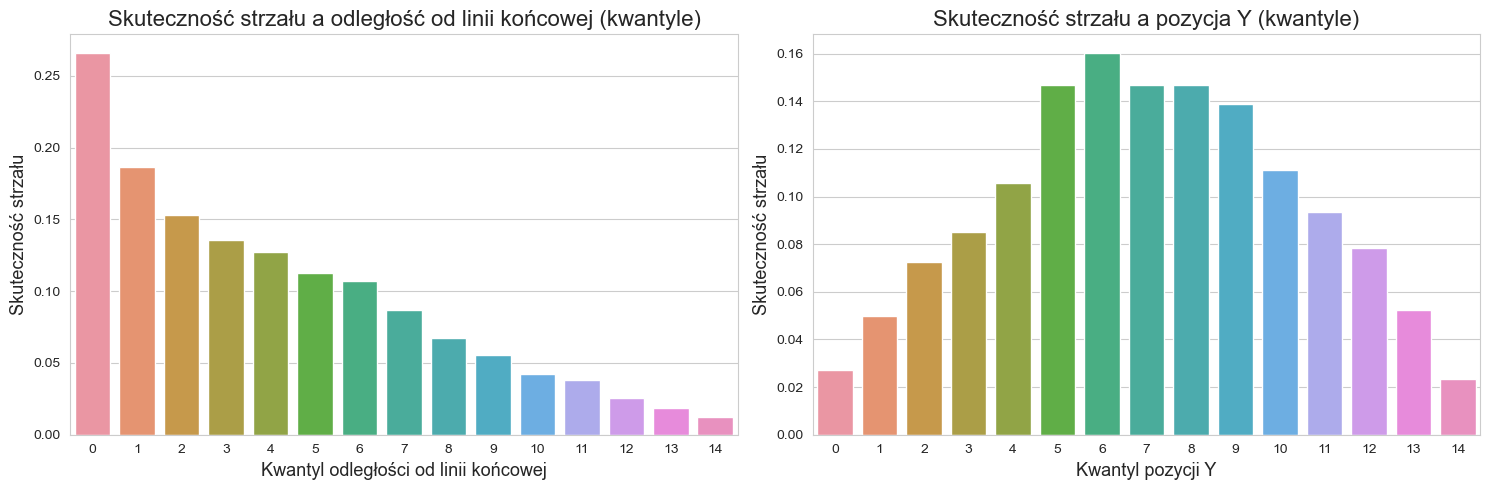

In [12]:
# Przygotowanie danych
eff_by_distance = create_quantile_efficiency(df_shots, 'distance_to_end_line', 'shot_outcome')
eff_by_y = create_quantile_efficiency(df_shots, 'y', 'shot_outcome')

plot_shot_accuracy_by_distance_and_y(eff_by_distance, eff_by_y)

Dzięki zastosowaniu kwantyli widzimy wyraźnie, że wraz ze wzrostem odległości od linii końcowej boiska skuteczność strzałów spada. Dla pierwszego kwantyla jest to ponad 25%, dla siódmego nieco ponad 10%, a dla ostatniego około 1-2%. Wyraźny wzorzec widać również dla wykresu skuteczności względem szerokości boiska (współrzędnej y). Strzały oddawane z pozycji centralnych charakteryzują się ponad 14% skuteczności, natomiast te z bocznych pozycji poniżej 5%.

Współrzędne x (a raczej 120-x) oraz y wydają się dobrymi zmiennymi różnicującymi. Można jednak zdefiniować dwie bardziej intuicyjne miary:
- **distance** - odległość od punktu, z którego oddano strzał (x,y) do środka bramki (120,40)
- **angle** - kąt jaki tworzy się między liniami łączącymi punkt strzału (x,y) ze słupkami bramki (120,36 oraz 120,44). Miara ta opisuje jak "duża" jest bramka z punktu widzenia strzelca. Będzie ona prawdopodobnie silnie negatywnie skorelowana ze zmienną **distance**, gdyż wraz ze wzrostem odległości będzie malał kąt.

In [13]:
df_shots = calculate_angles_distances(df_shots)

In [14]:
df_shots[['distance', 'angle']].describe()

,distance,angle
count,45233.000000,45233.000000
mean,19.520543,24.874447
std,8.713346,15.362327
min,0.632456,0.000000
25%,12.376187,14.859554
50%,19.027612,19.278945
75%,25.927784,30.401229
max,88.833158,180.000000


Zmienna **distance** przyjmuje wartości od 0.63 (bardzo bliski strzał) do 88.8 (strzał z odległości większej niż wynosi szerokość boiska). Średnia odległość strzału to około 19.5 jednostek i niemal pokrywa się z medianą wynoszącą 19 jednostek. W przypadku kąta strzału (**angle**) wartości kształtują się od 0 (uderzenie z linii końcowej) do 180 (strzały z linii bramkowej). Średnia kształtuje się na poziomie 24.9 stopni natomiast mediana jest niższa i wynosi 19.3 stopnia.

Patrząc na statystyki opisowe zmiennej angle można postawić hipotezę, że jest ona silnie skośna prawostronnie. Świadczą o tym: 
- średnia wyższa od mediany, 
- asmyetria kwartyli, gdyż rożnice między kolejnymi wartościami to: 15°, 4.5°, 11° oraz 150° (!),
- stosunkowo wysokie odchylenie standardowe w porównaniu z rozkładem kwartyli

W dalszej części przyjrzę się dokładniej domniemanej asymetrii rozkładu.

### Zmienne kategorialne

#### Część ciała - better_foot, worse_foot, head

Surowe dane zawarte w zmiennej **body_part** mogą mieć ograniczoną moc predykcyjną, w zwiazku z tym, że różni zawodnicy mają inną nogę domiującą, a co za tym idzie część z nich będzie preferować uderzenia nogą prawą, a część lewą. Dane StatsBomb nie zawierają informacji o tym, która noga u zawodnika jest preferowana, dominująca. W związku z tym, postanowiłem dla każdego zawodnika sprawdzić, którą nogą oddawał więcej strzałów i uznać tę nogę za jego dominującą. W przypadku sytuacji, gdy zawodnik oddał tyle samo strzałów obiema nogami postanowiłem zakwalifikować go wówczas do grupy prawonożnych, gdyż takich zawodników jest zdecydowanie więcej niż lewonożnych. Nowe dane przypisałem do zmiennej **refined_body_part**.

In [15]:
df_shots = transform_body_part(df_shots)

Rozkład dominującej nogi wśród zawodników:
foot_type
dominant_right    67.09
dominant_left     32.91
Name: proportion, dtype: float64
--------------------------------------------------
Rozkład strzałów wg rodzaju:
refined_body_part
better_foot    66.22
worse_foot     17.11
head           16.67
Name: proportion, dtype: float64


Po przeprowadzeniui powyższej klasyfikacji okazało się, że w zbiorze około 67% zawodników to zawodnicy prawonożni, a 33% stanowią zawodnicy lewnonożni. Po zastosowaniu feature engineering i utworzeniu **refined_body_part** otrzymałem nowy procentowy podział strzałów i zgodnie z nim 66% strzałów oddano lepszą nogą, 17% gorszą nogą i równiez około 17% to były strzały głową. Zgodnie z wcześniejszymi ustaleniami usunąłem obserwacje z etykietą "Others" gdyż stanowiły one jedynie 0.24% obserwacji.

#### Transformacja w zmienne binarne

Zgodnie z wcześniejszymi założeniami część zmiennych (**under_pressure**, **normal_shot**, **shot_first_time**, **open_play_shot**) przekształcam w zmienne binarne. Natomiast obserwacje z wartością *Corner* dla zmiennej **shot_type** usuwam ze zbioru (tylko 0.02% obserwacji).

In [16]:
# Przekształcenie zmiennych na binarne
df_shots = transform_to_binary(df_shots, 'under_pressure', positive_value=True, display_distribution=False)
df_shots = transform_to_binary(df_shots, 'shot_first_time', positive_value=True, display_distribution=False)

# Utworzenie nowych zmiennych binarnych na podstawie innych kolumn
# Dla shot_technique -> normal_shot
# Dla shot_type -> open_play_shot
df_shots['normal_shot'] = np.where(df_shots['shot_technique'] == 'Normal', 1, 0)
df_shots['open_play_shot'] = np.where(df_shots['shot_type'] == 'Open Play', 1, 0)

# Filtrowanie rzutów rożnych (tylko 0.02% obserwacji)
df_shots = df_shots[df_shots['shot_type'] != 'Corner']

# Reset indeksu
df_shots = df_shots.reset_index(drop=True)

#### Transformacja shot_freeze_frame w defenders_in_path oraz goalkeeper_in_path

Użyteczne informacje można wyciągnąć ze zmiennej **shot_freeze_frame**. Zawiera ona współrzędne lokalizacji zawodników w momencie oddania strzału. Dzięki temu możliwe jest określenie ilu obrońców znajdowało się w świetle bramki oraz czy bramkarz znajdował się na drodze piłki. Jako obszar "w świetle bramki" uznałem trójkąt wyznaczony przez zawodnika strzelającego oraz słupki bramki. Jeżeli obrońca lub bramkarz znajdował się w tym trójkącie to zakwalifikowałem go jako obecnego na linii strzału (gdyż w praktyce zasłaniał on część bramki przed strzelcem). 

In [17]:
df_shots = analyze_freeze_frame(df_shots)

Częstości obrońców na linii strzału:
defenders_in_path
0    48.57
1    34.26
2    10.95
3     4.12
4     1.56
5     0.43
6     0.08
7     0.02
8     0.01
Name: proportion, dtype: float64

Częstości obecności bramkarza na linii strzału:
goalkeeper_in_path
1    96.06
0     3.94
Name: proportion, dtype: float64


Zmienna **defenders_in_path** przyjmuje wartości od 0 do 8. Jednak zdecydowanie widać, że mniejsze wartości wyraźnie przeważają. W blisko 49% przypadków na drodze strzału nie było żadnego obrońcy, w 34% przypadków był jeden obrońca, w 11% akcji dwóch obrońców, a w 4% strzałów tych obrońców było trzech. Kolejne wartości są na tyle nieliczne, że postanowiłem je  **zgrupować razem z wartością 3**.

Z kolei zmienna **goalkeeper_in_path** to zmienna binarna, która przyjmuje wartośc 1 gdy bramkarz był w promieniu strzału oraz 0 w przeciwnym wypadku. W 96% strzałów bramkarz znajdował się między strzelcem a bramką. 

In [18]:
df_shots['defenders_in_path'] = np.where(df_shots['defenders_in_path'] >= 3, 3, df_shots['defenders_in_path'])

Niskie liczby obrońców znajdujących się na ścieżce strzału mogą wydawać się mało intuicyjne. Wydaje się, że strzałów oddawanych w gąszcz obrońców widuje się całkiem sporo. Warto jednak zastanowić się nad poniższymi argumentami:

- Dynamika akcji ofensywnych - Profesjonalne drużyny celowo konstruują akcje tak, by izolować obrońców i tworzyć przestrzenie. Dobrze przeprowadzony atak prowadzi do sytuacji, w której na linii strzału znajduje się minimalna liczba przeciwników.
- Geometria boiska - Przestrzeń przed bramką jest ograniczona, a zawodnicy atakujący poruszają się w sposób, który naturalnie rozciąga formacje obronne. Każdy napastnik próbuje znaleźć tak zwaną "lukę" w obronie, co z definicji oznacza minimalizację liczby obrońców na linii strzału.

Jak się okazuje zawodnicy atakujący przykładają dużą wagę do tego by choć na chwile znaleźć przestrzeń do oddania jak najczystszego strzału. Oczywiście nie zawsze jest to możliwe, dużo zależy również od sposobu w jaki broni się drużyna przeciwna.

W celu lepszego zobrazowania omawianych sytuacji przygotowałem również wizualizacje ukazującą strzały zgromadzone w omawianym zbiorze danych. Wpisując losową liczbę od 0 do 45107 można zobaczyć jak wyglądało ustawienie zawodników w momencie strzału. Zauważalne jest to, że często obrońcy byli blisko trójkąta oznaczającego promień strzału. Świadczy to o tym, że rzeczywiście napastnicy starają się znaleźć ten moment kiedy liczba  przeciwników na linii uderzenia jest najmniejsza.

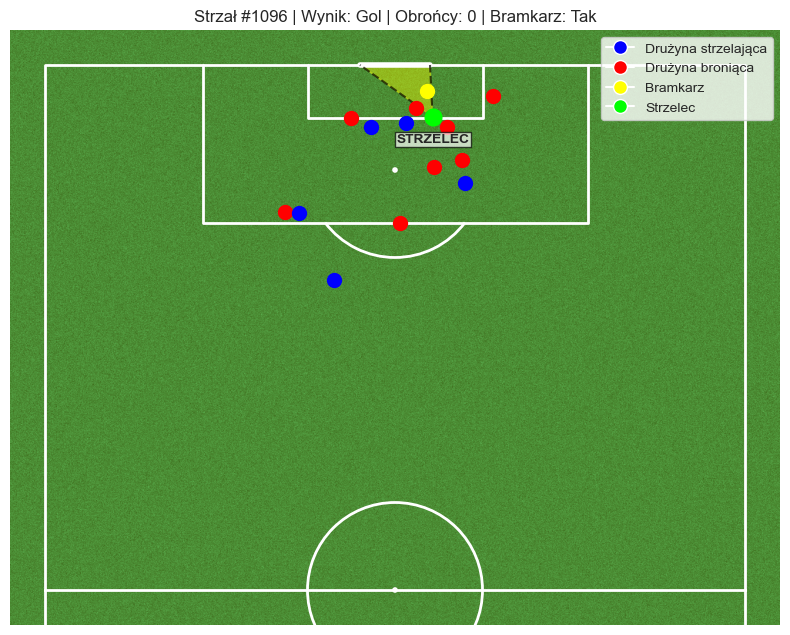

In [19]:
# Wizualizacja wybranego strzału
shot_index = 1096
fig, ax = visualize_shot_situation(df_shots, shot_index)
plt.show()

## Eksploracja danych

### Analiza zmiennych binarnych względem zmiennej objaśnianej

W celu lepszego zrozumienia danych przyjrzałem się jak różni się skuteczność strzałów w zależności od wartości zmiennych binarnych (0/1). W tym celu stworzyłem wykresy kolumnowe dla zmiennych: **under_pressure**, **shot_first_time**, **normal_shot**, **open_play_shot**, **goalkeeper_in_path**. Lewa kolumna ilustruje procentową skuteczność dla obserwacji które dla danej zmiennej przyjmują wartość 0, natomiast prawa kolumna skutecznośc dla strzałów z etykietą 1 dla danej zmiennej.

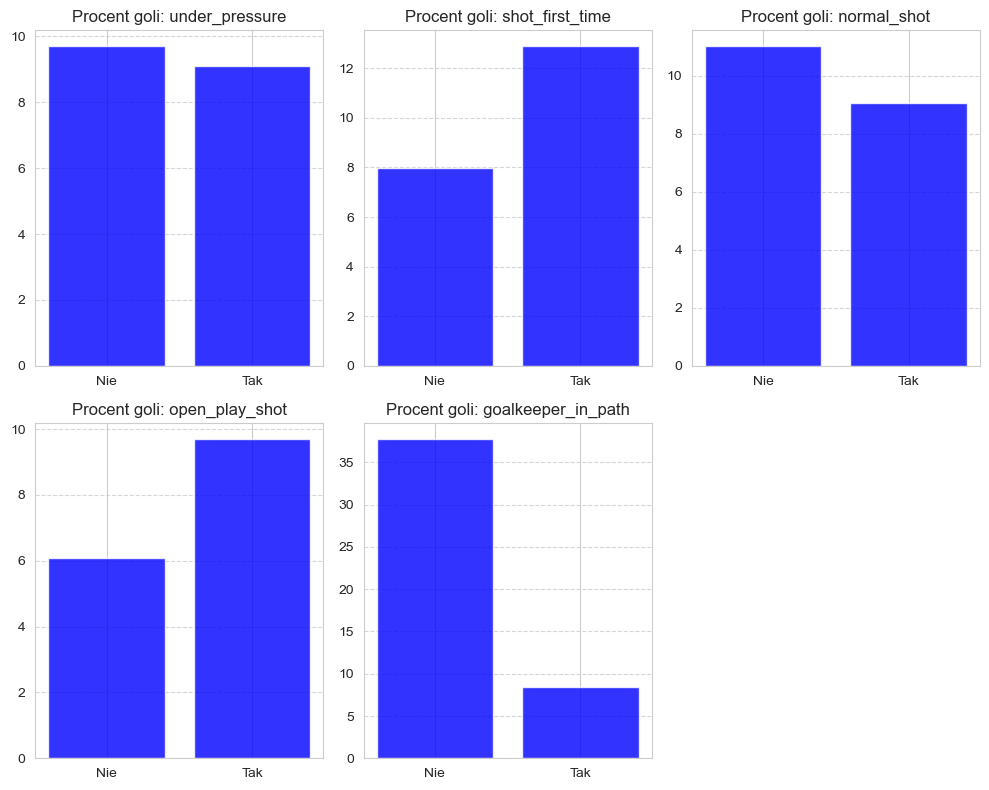

In [20]:
bin_features = ['under_pressure', 'shot_first_time', 'normal_shot', 'open_play_shot', 'goalkeeper_in_path']
plot_binary_features_comparison(df_shots, features=bin_features)

##### Under_pressure
- Strzały bez presji mają nieco wyższą skuteczność (ok. 9.8%) niż strzały pod presją (ok. 9.0%)
- Różnica jest stosunkowo niewielka, co sugeruje, że presja przeciwnika ma umiarkowany wpływ na skuteczność

##### Shot_first_time
- Strzały z pierwszej piłki mają znacznie wyższą skuteczność (ok. 12.5%) niż strzały poprzedzone kontrolą piłki (ok. 8%)
- To może wynikać z elementu zaskoczenia dla bramkarza lub faktu, że strzały z pierwszej piłki są zazwyczaj oddawane w lepszych sytuacjach

##### Normal_shot
- Normalne strzały mają wyższą skuteczność (ok. 10.7%) niż strzały wykonywane specjalnymi technikami (ok. 8.9%)
- Sugeruje to, że prostsze uderzenia są często bardziej efektywne niż te ekwilibrystyczne, bardziej zjawiskowe

##### Open_play_shot
- Strzały z akcji mają wyższą skuteczność (ok. 9.7%) niż strzały bezpośrednio z rzutów wolnych (ok. 6.0%)
- Ten wynik może być zaskakujący, bo stałe fragmenty gry są często uważane za dobre okazje bramkowe, ale z drugiej strony zarówno obrońcy jak i bramkarz są lepiej przygotowani do oddania strzału.

##### Goalkeeper_in_path
- Tutaj widać najwyraźniejszą różnicę: strzały bez bramkarza na linii mają skuteczność ok. 37.5%, podczas gdy strzały z bramkarzem na drodze tylko ok. 8.5%
- To potwierdza kluczową rolę bramkarza w obronie bramki - jego obecność w ścieżce strzału zmniejsza szansę na gola ponad czterokrotnie

Ta analiza pokazuje, że dla modelu xG kluczową zmienną może być obecność bramkarza na linii strzału. Inne zmienne, takie jak strzał z pierwszej piłki czy normalny strzał, również mają zauważalny wpływ na prawdopodobieństwo zdobycia bramki.

### Analiza skuteczności strzału w zależności od części ciała *(refined_body_part)*

Kolejną zmienną, której postanowiłem się przyjrzeć była **refined_body_part**. Zmienna ta zawiera trzy kategorie: *better_foot*, *worse_foot*, *head*. Intuicja podpowiada, że strzały wykonywane lepszą nogą powinny być zdecydowanie bardziej skuteczne niż te wykonywane słabszą. Dodatkowo noga dominująca powinna raczej gwarantować więcej goli niż strzały głową, które często są oddawane z trudnych sytuacji, w otoczeniu wielu obrońców.

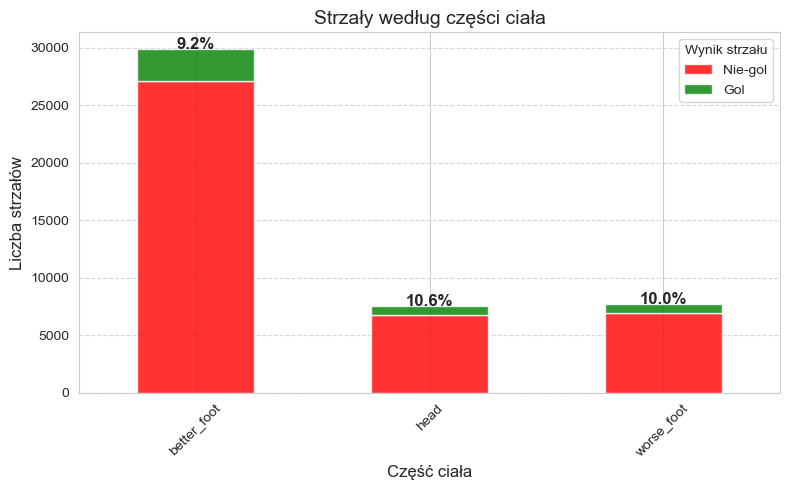

In [21]:
plot_stacked_bar(df_shots, 'refined_body_part', 'Strzały według części ciała', 'Część ciała')

Najwięcej strzałów jest oddawanych lepszą nogą, udział strzałów oddanych gorszą nogą jest porównywalny do strzałów oddanych głową i razem stanowią około połowy wolumenu wygenerowanego przez strzały lepszą nogą. Mimo to skuteczność dla wszystkich częsci ciała jest podobna i wynosi około 9-11%. Nie pokrywa się to z intuicyjnym podejściem. Z czego to może wynikać? Uderzając lepszą nogą piłkarze mogą być bardziej skłonni do ryzyka, tj. uderzenia z większego dystansu czy nieprzygotowanej pozycji. Dodatkowo piłkarze z silnie dominującą jedną nogą może być łatwiejsi do "przeczytania" przez obrońców i bramkarzowa (choć istnieją wyjątki jak legendarny Arjen Robben i jego zejście na lewą nogę). W celu lepszego zrozumienia tego nieintuicyjnego zjawiska stworzyłem wykres kolumnowy skumulowany pokazujący udział strzałów oddanych każdą częscią ciała (z tych trzech rozważanych) w zalezności od kwantyla dystansu.

<Figure size 1000x600 with 0 Axes>

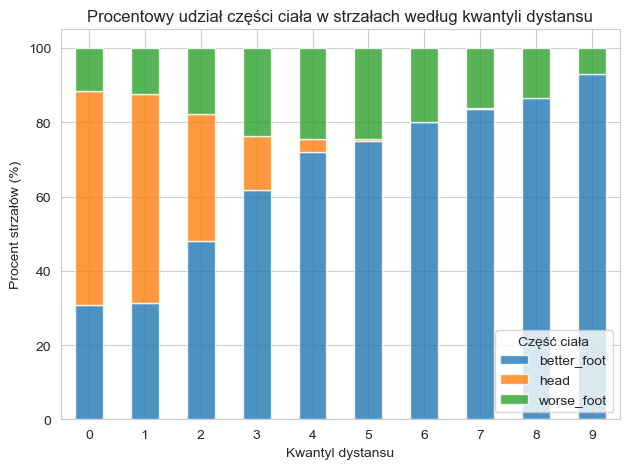

In [22]:
plot_body_part_by_distance_quantile(df_shots)

Powyższy wykres zdaje się potwierdzać tezę, że strzały lepszą nogą są zwykle oddawana z gorszej pozycji, z dalszej odległości. Po podzieleniu strzałów na 10 równolicznych kwantyli okazuje się, że w najniższych kwantylach (najlepsze pozycje) udział strzałów lepszą nogą to jedynie około 30%, natomiast w ostatnich czterech kwantylach ten udział przekracza 80%. Odwrotną sytuację widzimy ze strzałami głową - blisko 60% w pierwszym kwantylu i stopniowy spadek aż do szczątkowych wartości w 6. kwantylu. W przypadku strzałów słabszą nogą widzimy mały udział (ok.10-15%) w pierwszych kwantylach co jest spowodowane dużym udziałem strzałów głową. Natomiast wraz ze spadkiem udziału tej kategorii widzimy wzrost udziału strzałów słabszą nogą aż do kwantyli 4 i 5 kiedy to następuje stopniowe ustępowaniem strzałom wykonanym lepszą nogą. Powyższa obserwacja sygnalizuje, że choć całościwo skutecznośc nie jest zrożnicowana dla różnych częsci ciała to jednak wraz ze zmienną *distance* może pozytywnie wpłynąć na moc predykcyjną modelu.

### Analiza zmiennej porządkowej *(defenders_in_path)*

Kolejnym czynnikiem, który wydaje się niezwykle istotny dla skuteczności strzału wydaje się ilośc obrońców na drodze strzału (**defenders_in_path**). Jak zauważyłem we wcześniejszej częsci analizy zdecydowana większość strzałów jest oddawana w sytuacji, gdy na tej potencjalnej ścieżce strzału nie ma żadnego obrońcy (49% obserwacji) lub jest tylko jeden (34% obserwacji). Wydaje się zatem, że dla strzelca bardzo istotne jest minimalizowanie liczby przeciwników na odcinku między nim a bramką. Jeśli rzeczywiście jest to korzystne to powinny potwierdzać to dane.

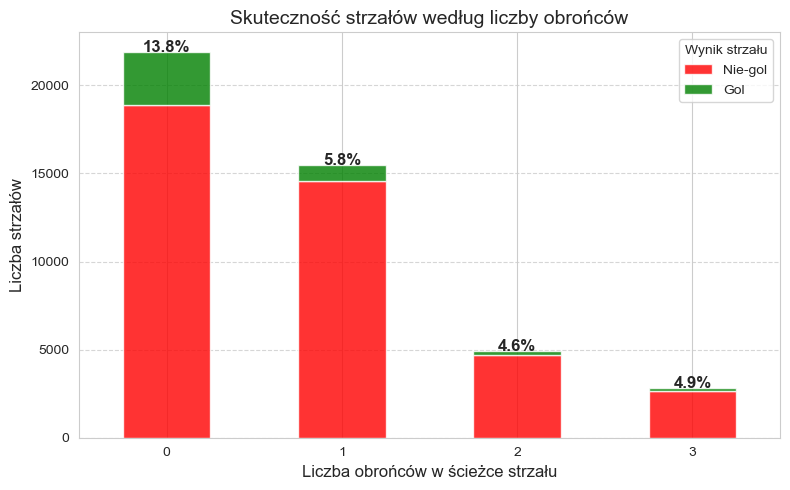

In [23]:
plot_stacked_bar(df_shots, 'defenders_in_path', 'Skuteczność strzałów według liczby obrońców', 'Liczba obrońców w ścieżce strzału')

Rzeczywiście w danych mamy potwierdzenie logiki, którą kierują się strzelcy. Strzały bez obrońców w ścieżce (*kategoria 0*) mają zdecydowanie najwyższą skuteczność - 13.8% tych strzałów kończy się bramką. Po pojawieniu się jednego obrońcy ta skutecznośc spada ponad dwukrotnie do 5.8%. Każdy kolejny obrońca na linii strzału nie wpływa już w tak wielkim stopniu na utrudnianie w zdobyciu bramki i dla sytuacji, gdy jest minimum dwóch obrońców wskaźnik skuteczności utrzymuje się nieco poniżej 5%.

Ta analiza jasno pokazuje, że liczba obrońców w ścieżce strzału jest bardzo ważnym czynnikiem przy modelowaniu xG. Szczególnie istotna jest różnica między strzałami bez obrońców a strzałami z choćby jednym obrońcą w ścieżce, co jest istotnym sygnałem dla drużyn broniących, że nawet jeden obrońca potrafi znacząco utrudnić zdobycie bramki. Natomiast wolumen strzałów bez obrońcy oraz z jednym obrońcą pokazuje jak ważne dla strzelców jest znalezienie optymalnej pozycji w odpowiednim czasie by oddać strzał i zmaksymalizować szanse na zdobycie bramki.

### Zmienne ciągłe: odległosć i kąt strzału

Obydwie zmienne ciągłe, tj. **distance** oraz **angle**, są oparte na tych samych surowych zmiennych, czyli **x** i **y** wyciągniętych ze zmiennej **location**. Powoduje to obawę, że mogą być one silnie zależne od siebie. W celu lepszego przyjrzenia się tym zmiennym stworzyłem heatmapę pokazującą jak zmienia się skuteczność strzału w zależności od kwantyla kąta i dystansu, a także wyznaczyłem macierz korelacji dla tych zmiennych.

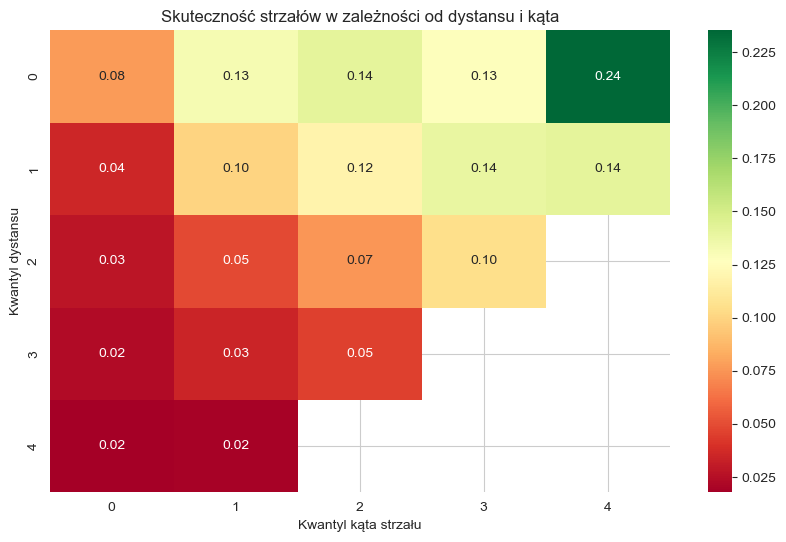

             angle  distance
angle     1.000000 -0.757387
distance -0.757387  1.000000


In [24]:
plot_shot_success_heatmap(df_shots, quantiles=5, show_corr=True)

Słuszne były obawy o silną zależność obu zmiennych, gdyż jak wskazuje macierz wysepuje między nimi silna korelacja ujemna równa aż -0.75 (im większa odległość od bramki, tym mniejszy kąt strzału). 

Po analzie heatmapy możemy potwierdzić, że najwyższa skuteczność strzałów (0.24, czyli 24%) występuje przy małych odległościach i dużych kątach strzału, co jest zgodne z intuicją piłkarską. Gradient skuteczności jest widoczny zarówno wzdłuż osi odległości jak i kąta, ale wartości wzdłuż wierszy (dla stałej odległości) sugerują, że kąt strzału może być lepszym indywidualnym predyktorem skuteczności. Skuteczność drastycznie spada przy dużych odległościach, osiągając zaledwie 2% przy najdalszych strzałach. Przy dużych odległościach kąt strzału jest zawsze stosunkowo mały (co wynika z samej geometrii), co dodatkowo utrudnia zdobycie bramki.

Współliniowość zmiennych stanowi wyzwanie dla modelowania. Mimo silnej korelacji, zdecydowałem się zachować obie zmienne w dalszej analizie, planując zastosowanie technik regularyzacji w procesie modelowania, aby kontrolować potencjalne problemy związane ze współliniowością.

Ta analiza dostarcza cennych informacji o geometrycznych aspektach wpływających na skuteczność strzałów i będzie stanowić podstawę do budowy modelu expected goals (xG). Na potwierdzenie rozważań przygotowałem również wykres kolumnowy pokazujący jaka była skutecznośc strzału w zależności od kwantyla dystansu oraz analogiczny z podziałem na kwantyle kąta (tym razem podzieliłem dane na 15 kwantyli dla lepszego zobrazowania).

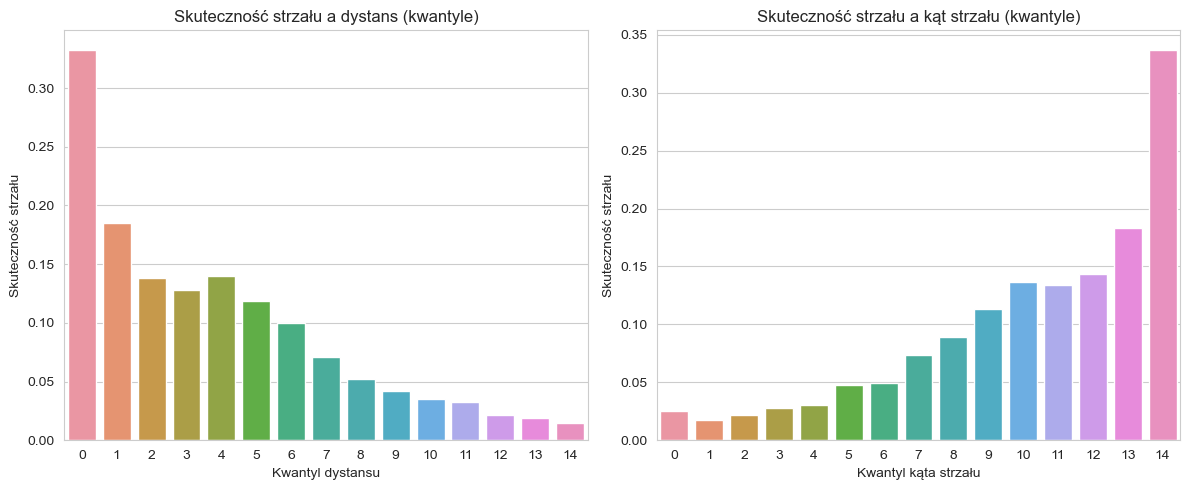

In [25]:
plot_shot_effectiveness_by_quantiles(df_shots)

In [26]:
distance_skew = stats.skew(df_shots['distance'])
angle_skew = stats.skew(df_shots['angle'])

print("Skośność zmiennych:")
print(f"Odległość: {distance_skew:3f}")
print(f"Kąt strzału: {angle_skew:3f}")

Skośność zmiennych:
Odległość: 0.578014
Kąt strzału: 2.182529


W przypadku dystansu widzimy wyraźnie, że im większa odległość (wyższy kwantyl) tym mniejsza skuteczność strzału. Odwrotna sytuacja jest dla kąta strzału. Szansa rośnie z każdym kolejnym kwantylem - a zatem wraz ze wzrostem kąta strzału. Dodatkowo sprawdziłem skośność obu zmiennych ciągłych za treshold przyjmując wartośc 1. Zgodnie z przypuszczeniami silnie skośny jest rozkład kąta strzału (2.18) i na tej zmiennej bedzie konieczne zastosowanie logarytmizacji.

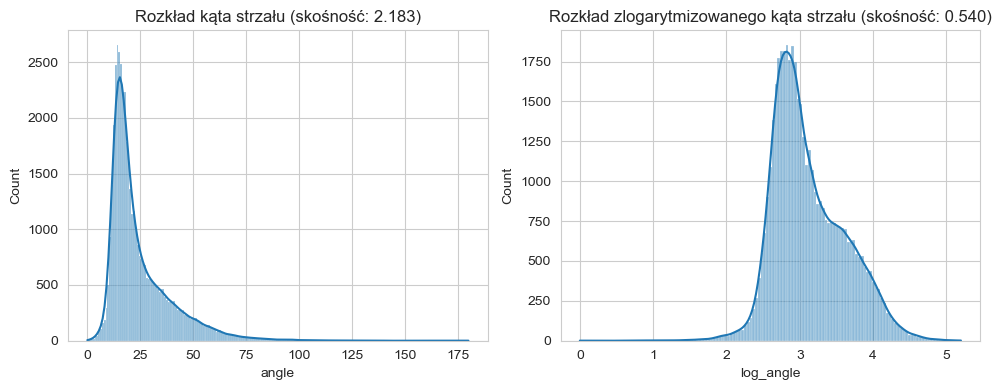

Skośność oryginalnych zmiennych:
Kąt strzału: 2.183

Skośność zlogarytmizowanych zmiennych:
Log(kąt strzału): 0.540


In [27]:
plot_angle_distribution(df_shots)

Analiza rozkładu zmiennej **angle** wykazała silną prawostronną asymetrię (skośność = 2.183). Większość obserwacji koncentrowała się w przedziale małych kątów (poniżej 25 stopni), co odpowiada trudniejszym sytuacjom strzeleckim, natomiast duże kąty (odpowiadające lepszym pozycjom) występują naturalnie znacznie rzadziej.
Zastosowanie transformacji logarytmicznej istotnie poprawiło rozkład zmiennej, redukując skośność do wartości 0.540. Uzyskany rozkład jest znacznie bliższy normalnemu, co zwiększy skuteczność modelowania statystycznego. Dzięki tej transformacji wpływ kąta strzału na prawdopodobieństwo zdobycia bramki zostanie lepiej uchwycony w całym zakresie wartości, co powinno przełożyć się na poprawę jakości modelu expected goals.

### Standaryzacja i dummy encoding

Po przeanalizowaniu zmiennych kolejnym krokiem była standaryzacja zmiennych ciągłych, gdyż jeden z przyszłych modeli - Regresja Logistyczna - wymaga takiego działania (pozostałe, tj. Lasy Losowe oraz XGBoost, nie wymagają). Dodatkowo wywołałem statystki opisowe dla tych zmiennych, aby ocenić czy transformacja przebiegła poprawnie.

In [28]:
continuous_vars = ['distance', 'log_angle']
df_shots = standardize_features(df_shots, continuous_vars)
df_shots[['distance_scaled', 'log_angle_scaled']].describe()

,distance_scaled,log_angle_scaled
count,4.510800e+04,4.510800e+04
mean,-1.625610e-16,-1.241260e-15
std,1.000011e+00,1.000011e+00
min,-2.174349e+00,-6.344615e+00
25%,-8.203967e-01,-7.228099e-01
50%,-5.600621e-02,-2.251189e-01
75%,7.352403e-01,6.610891e-01
max,7.966568e+00,4.231395e+00


Standaryzacja przebiegła zgodnie z założeniami, tj. średnia zestandaryzowanych zmiennych jest bliska 0, a odchylenie standardowe wynosi 1. Małe odchylenia od idealnych wartości wynikają z ograniczonej precyzji obliczeń zmiennoprzecinkowych i są całkowicie normalne.

Następnym krokiem przygotowania zmiennych było stworzenie dummies na zmiennej kategorialnej (niebinarnej), czyli **refined_body_part**. W tym procesie powstały dwie nowe zmienne binarne: **better_foot**, **worse_foot**. W celu uniknięcia współliniowości usunąłem zmienną **head**. Wartości 0 dla obu zmiennych oznaczających strzał nogą są tożsame ze strzałem głową.

In [29]:
df_shots = create_dummies(df_shots, 'refined_body_part', drop_category='head')

Ostatnią rzeczą jaką sprawdziłem przed rozpoczęciem budowy modelu była współliniowość zmiennych. W tym celu posłużyłem się VIF (Variance Inflation Factor). Przyjąłem następującą interpretację:
- VIF = 1: brak współliniowości
- 1 < VIF < 5: umiarkowana współliniowość
- 5 < VIF < 10: wysoka współliniowość (rozważenie usunięcia zmiennej)
- VIF > 10: bardzo wysoka współliniowość (usunięcie zmiennej)

In [30]:
features1 = ['distance_scaled', 'log_angle_scaled', 'under_pressure', 
             'shot_first_time', 'better_foot', 'worse_foot', 'normal_shot', 
             'open_play_shot', 'defenders_in_path', 'goalkeeper_in_path']
vif_data1 = calculate_vif(df_shots, features1)
print(vif_data1)

             Variable        VIF
9  goalkeeper_in_path  17.504479
7      open_play_shot  16.520393
4         better_foot   7.743056
6         normal_shot   4.576439
1    log_angle_scaled   3.598026
0     distance_scaled   3.575117
5          worse_foot   2.598610
3     shot_first_time   2.217216
8   defenders_in_path   1.929464
2      under_pressure   1.533719


Okazuje się, że bardzo wysoką współliniowość wykazują dwie zmienne: **goalkeeper_in_path** oraz **open_play_shot**. W związku z przyjętą interpretacją postanowiłem usunąc te dwie zmienne i zobaczyć jak wpłynie to na pozostałe zmienne (zwłaszcza na **better_foot**, które również ma dość wysoki wskaźnik VIF).

In [31]:
features2 = ['distance_scaled', 'log_angle_scaled', 'under_pressure', 
             'shot_first_time', 'better_foot', 'worse_foot', 'normal_shot', 'defenders_in_path']
vif_data2 = calculate_vif(df_shots, features2)
print(vif_data2)

            Variable       VIF
4        better_foot  4.285506
0    distance_scaled  3.502131
1   log_angle_scaled  3.485778
6        normal_shot  3.051030
3    shot_first_time  2.147688
7  defenders_in_path  1.745667
5         worse_foot  1.727796
2     under_pressure  1.404169


Po usunięciu dwóch zmiennych z najwyższą współliniowością spadła współliniowość innych zmiennych, w tym **better_foot**, dla której wartość współczynnika VIF wynosi teraz 4.29 co jest akceptowalnym poziomem.

### Usunięcie zmiennych nieistotnych

Na koniec definitywnie usunąłem wspomniane wyżej dwie zmienne i w ten sposób zakończyłem proces przygotowywania zmiennych oraz ich selekcji.

In [32]:
df_shots = df_shots[[
        'shot_outcome', 'under_pressure',
       'shot_first_time', 'distance_scaled', 'log_angle_scaled', 
        'better_foot', 'worse_foot',
        'normal_shot', 'defenders_in_path']]

print(df_shots.shape)
print(df_shots.head())

(45108, 9)
   shot_outcome  under_pressure  shot_first_time  distance_scaled  \
0             1               1                0        -1.202813   
1             0               0                0         1.373219   
2             0               1                0        -1.123302   
3             0               0                1        -0.048027   
4             0               0                1         0.298258   

   log_angle_scaled  better_foot  worse_foot  normal_shot  defenders_in_path  
0          1.395579            0           0            1                  0  
1         -1.274038            1           0            1                  2  
2          1.413147            0           0            1                  0  
3         -1.086465            0           1            0                  1  
4         -0.771647            1           0            1                  0  


## BUDOWA MODELI

### PODZIAŁ NA ZBIORY: TRENINGOWY, WALIDACYJNY I TESTOWY

W finalnym zbiorze danych pozostało 45 108 obserwacji z 1 zmienną objaśnianą (**shot_outcome**) oraz 8 zmiennymi objaśniającymi (**under_pressure**, **shot_first_time**, **distance_scaled**, **log_angle_scaled**,  **better_foot**, **worse_foot**, **normal_shot**, **defenders_in_path**).

W celu modelowania podzieliłem zbiór danych na trzy podzbiory:

1. **Zbiór treningowy (60%)** - używany do trenowania modelu. Na tym zbiorze stosuję undersampling, aby zbalansować klasy (gole i nie-gole). Dzięki temu model lepiej uczy się cech charakterystycznych dla sytuacji bramkowych.

2. **Zbiór walidacyjny (20%)** - używany wyłącznie do kalibracji modelu. Na tym zbiorze obliczam współczynnik kalibracji (zaburzony przez resampling w zbiorze treningowym), który pozwala dostosować przewidywane prawdopodobieństwa. Kluczowe jest, że ten zbiór zachowuje naturalny rozkład klas, co umożliwia wiarygodną kalibrację.

3. **Zbiór testowy (20%)** - używany do ostatecznej oceny modelu. Tutaj ewaluuję zarówno model bez kalibracji, jak i z kalibracją, aby porównać ich wydajność. Podobnie jak zbiór walidacyjny, zachowuje naturalny rozkład klas.

Takie podejście zapewnia metodologiczną poprawność, ponieważ każda faza (trenowanie, kalibracja, testowanie) wykorzystuje niezależne dane, co zapobiega wyciekowi informacji (*data leakage*) między etapami i daje bardziej wiarygodną ocenę modelu.

In [33]:
X = df_shots.drop(['shot_outcome'], axis=1)
y = df_shots['shot_outcome']

X_train, X_val, X_test, y_train, y_val, y_test = prepare_train_test_split(X, y)

print(f"Rozmiar zbioru treningowego: {X_train.shape[0]}")
print(f"Rozmiar zbioru walidacyjnego: {X_val.shape[0]}")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]}")

Proporcja goli po undersamplingu w zbiorze treningowym: 0.30
Rozmiar zbioru treningowego: 8653
Rozmiar zbioru walidacyjnego: 9022
Rozmiar zbioru testowego: 9022


C:\Users\Bartek\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\Bartek\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### ZDEFINIOWANIE EWALUACJI

#### Metoda kalibracji

W projekcie zdecydowałem się na zastosowanie **Beta Calibration** jako metody kalibracji dla modeli xG. Ta decyzja wynika z kilku kluczowych powodów.Przede wszystkim ze względu na jej skuteczność w pracy również z **modelami drzewiastymi jak Random Forest czy XGBoost**, które często mają problem z właściwym oszacowaniem prawdopodobieństw. Metoda ta oferuje **większą elastyczność** dzięki trzem parametrom (a, b, c), co pozwala lepiej dopasować transformację do różnych wzorców błędów kalibracji. W przeciwieństwie do prostszych metod, Beta Calibration radzi sobie doskonale ze **skrajnymi wartościami prawdopodobieństw**, co jest szczególnie istotne w modelowaniu xG, gdzie większość strzałów ma niskie prawdopodobieństwo sukcesu. Dodatkowo, **nieliniowa natura** tej transformacji lepiej odpowiada skomplikowanym wzorcom błędów kalibracji, które występują w modelowaniu sytuacji piłkarskich.

#### Implementacja kalibracji

Beta Calibration jest implementowana poprzez:
1. Przekształcenie surowych predykcji modelu na skalę logitową
2. Zastosowanie transformacji parametrycznej z trzema parametrami (a, b, c)
3. Przekształcenie z powrotem na skalę prawdopodobieństwa [0,1]

Parametry kalibracji (a, b, c) są optymalizowane na zbiorze walidacyjnym, minimalizując funkcję straty logarytmicznej (log loss). Jest to metodologicznie poprawne podejście, które **zapobiega wyciekowi informacji** między etapami trenowania modelu i jego kalibracji.

Oczekuję, że zastosowanie Beta Calibration znacząco poprawi jakość przewidywań modeli xG, szczególnie w zakresie kalibracji prawdopodobieństw i globalnej zgodności sumy xG z rzeczywistą liczbą goli.

#### Miary ewaluacyjne

Do oceny modeli wybrałem następujące mierniki, które najlepiej odzwierciedlają skuteczność przewidywania jakości sytuacji strzeleckich:

1. **ROC AUC (Area Under the Curve)** - mierzy zdolność modelu do rozróżniania między sytuacjami, które zakończą się golem a tymi, które nie. W przypadku xG, ważne jest nie tylko to, czy model przewiduje gola, ale czy dobrze ocenia relatywne prawdopodobieństwo różnych sytuacji strzeleckich. Dla swoich modeli oczekuję wyników powyżej 0.75 (idealny = 1.0, losowy = 0.5).

2. **Brier Score** - mierzy jakość kalibracji modelu probabilistycznego, czyli jak dobrze przewidywane prawdopodobieństwa odpowiadają rzeczywistym wynikom. W kontekście xG oznacza to, czy sytuacje o przewidywanej wartości xG = 0.3 faktycznie kończą się golem w 30% przypadków. Oczekuję wyników poniżej 0.1 – im niższy wynik, tym lepsza kalibracja modelu.

3. **Log Loss** - ocena pewności modelu w przypisywaniu prawdopodobieństw. Model jest karany za bycie "pewnym" w błędnych predykcjach, np. gdy przypisuje xG = 0.9, a strzał nie kończy się golem. W przypadku xG log loss pozwala ocenić, jak dobrze model oddaje niepewność sytuacji strzeleckich. Oczekuję wartości poniżej 0.3.

4. **Współczynnik xG/Goals** - stosunek sumy przewidywanych xG do rzeczywistej liczby goli. Ten wskaźnik pozwala ocenić, czy model globalnie poprawnie przewiduje liczbę bramek. Wartość idealna to 1.0 - oznaczająca, że suma wszystkich xG odpowiada rzeczywistej liczbie goli. Akceptowalny zakres to 0.9-1.1.

Ewaluację wzbogacę również o trzy kluczowe wizualizacje:

1. **Krzywa ROC** - pozwala ocenić, jak model radzi sobie z rozróżnianiem między sytuacjami bramkowymi a niebramkowymi

2. **Porównanie przewidywanych xG z rzeczywistą liczbą goli** - wykres słupkowy pozwalający łatwo porównać sumę przewidywanych xG z faktyczną liczbą bramek.

3. **Reliability Diagram** - pokazuje, jak dobrze skalibrowany jest model w różnych przedziałach prawdopodobieństwa. Linia bliższa przekątnej oznacza lepszą kalibrację.

Ze względu na naturę modelowania Expected Goals, skupię się głównie na ocenie jakości przewidywanych prawdopodobieństw (kalibracja), a nie na miarach klasyfikacji binarnej. Model xG ma przede wszystkim przypisywać wiarygodne prawdopodobieństwa sytuacjom strzeleckim, a nie klasyfikować je jako "gol" lub "nie-gol". W związku z tym zrezygnowałem z miar takich jak **Confusion Matrix** oraz powiązanych z tym **Precision** i **Recall**, a priorytetowo traktuję metryki takie jak **Brier Score**, **Log Loss** i **ROC AUC**, które pozwalają ocenić jakość probabilistycznych predykcji.

### Model 1 - Regresja Logistyczna

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Najlepsze parametry: {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Najlepszy wynik: 0.7878

Wyniki modelu:


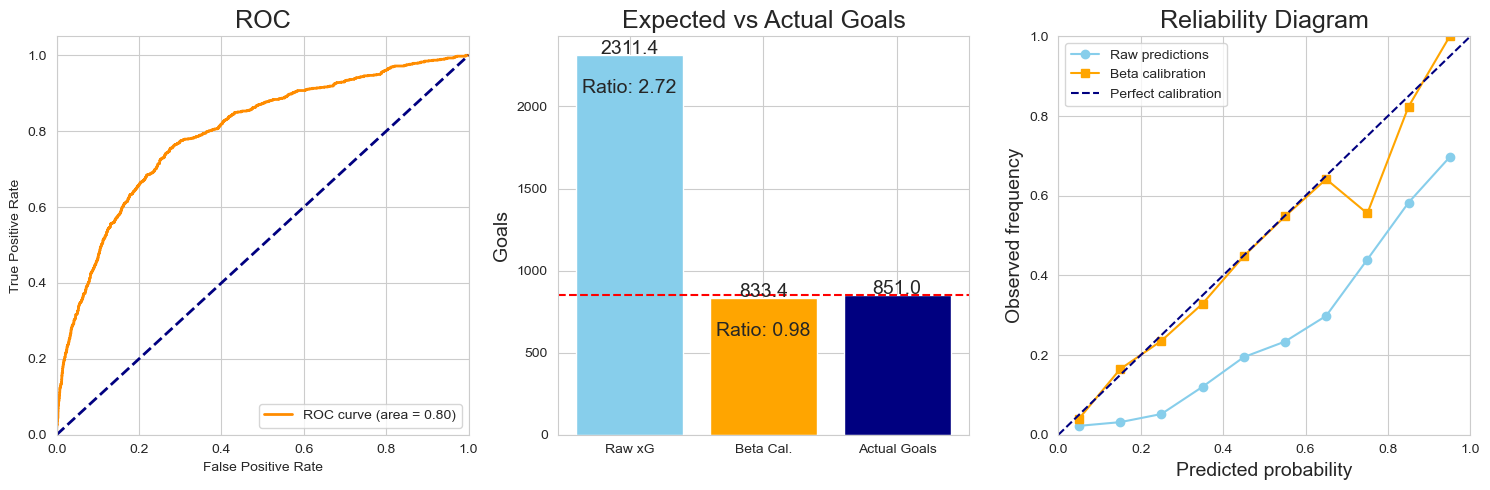

ROC AUC: 0.7962
Brier Score (Raw): 0.1073
Brier Score (Beta): 0.0728
Log Loss (Raw): 0.3596
Log Loss (Beta): 0.2573
xG/Goals Ratio: 2.7162
Beta xG/Goals Ratio: 0.9794


In [34]:
metrics_log_reg = train_logistic_regression(X_train, y_train, X_val, y_val, X_test, y_test)

#### Parametry modelu
Najlepszy model regresji logistycznej wykorzystuje **umiarkowaną regularyzację** (C=1, penalty='l1'), **bez dodatkowego ważenia klas**, co wskazuje że undersampling skutecznie zbalansował dane treningowe.

#### Metryki wydajności
Model osiąga solidne **ROC AUC 0.796** i niski **Brier Score 0.107** przed kalibracją, co świadczy o dobrej zdolności różnicowania między sytuacjami bramkowymi. Jednak surowy model ma poważny problem z kalibracją prawdopodobieństw, co widać w wysokim współczynniku xG/Goals wynoszącym **2.72**.

Po zastosowaniu kalibracji Beta:
- **Brier Score** poprawia się znacząco do **0.073** (poprawa o 32%)
- **Log Loss** spada z 0.360 do 0.257 (poprawa o 29%)
- **Współczynnik xG/Goals** obniża się do niemal idealnego **0.98**

#### Analiza błędów
Reliability Diagram ujawnia, że surowy model systematycznie i znacząco przeszacowuje prawdopodobieństwa w całym ich zakresie. Kalibracja Beta niemal **bardzo dobrze koryguje** te błędy, co widać w linii kalibracji przebiegającej bardzo blisko linii idealnej, szczególnie w przedziale **0-0.7**.

#### Podsumowanie
Model xG oparty na regresji logistycznej prezentuje zadowalające wyniki w zakresie **dyskryminacji** (ROC AUC 0.796), ale wymaga bezwzględnie kalibracji Beta, która dramatycznie poprawia jakość przewidywanych prawdopodobieństw. Dzięki kalibracji model staje się wiarygodnym narzędziem do:
- Porównywania **relatywnej jakości sytuacji strzeleckich** (zachowane ROC AUC)
- Generowania dobrze skalibrowanych wartości xG (Brier Score 0.073)
- Przewidywania **globalnie poprawnej liczby goli** (xG/Goals ≈ 1)

Kalibracja Beta okazuje się kluczowym elementem, bez którego model przeszacowuje jakość sytuacji strzeleckich ponad 2,5-krotnie, co czyniłoby go bezużytecznym w praktycznej analizie piłkarskiej.

### Model 2 - Lasy Losowe


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Najlepsze parametry: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Najlepszy wynik: 0.7856

Wyniki modelu:


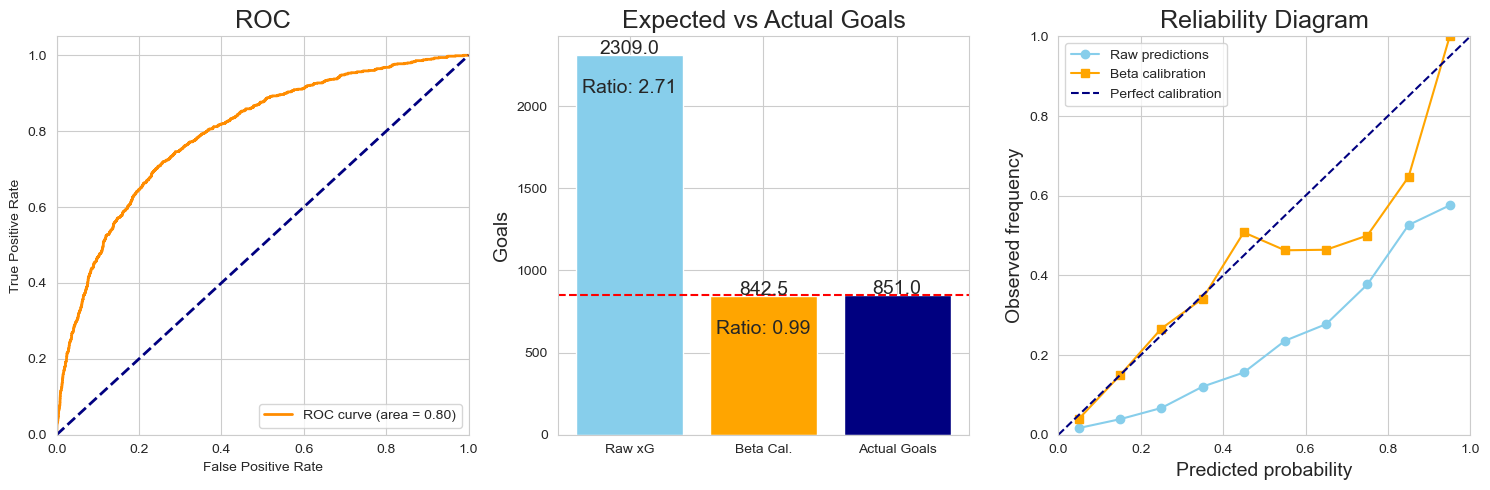

ROC AUC: 0.7964
Brier Score (Raw): 0.1105
Brier Score (Beta): 0.0739
Log Loss (Raw): 0.365
Log Loss (Beta): 0.2589
xG/Goals Ratio: 2.7133
Beta xG/Goals Ratio: 0.99


In [35]:
metrics_rf = train_random_forest(X_train, y_train, X_val, y_val, X_test, y_test)

#### Parametry modelu
Najlepszy model XGBoost wykorzystuje **pełną próbę obserwacji** na każde drzewo (colsample_bytree=1.0), **niską wartość współczynnika uczenia** (learning_rate=0.1), **płytkie drzewa** o maksymalnej głębokości 3, z całkowitą liczbą estymatorów wynoszącą **100**. Model wykorzystuje również **losowe próbkowanie 80% danych** (subsample=0.8) przy budowie każdego drzewa. Te hiperparametry wskazują na zrównoważone podejście zapobiegające przeuczeniu.

#### Metryki wydajności
Model osiąga najwyższe **ROC AUC 0.798** spośród wszystkich testowanych modeli i **Brier Score 0.108** przed kalibracją. Podobnie jak poprzednie modele, XGBoost również cierpi na problem przeszacowania prawdopodobieństw, co widać w wysokim współczynniku xG/Goals wynoszącym **2.70**.

Po zastosowaniu kalibracji Beta:
- **Brier Score** poprawia się znacząco do **0.073** (poprawa o 32%)
- **Log Loss** spada z **0.359** do **0.257** (poprawa o 28%)
- **Współczynnik xG/Goals** obniża się do niemal idealnego **0.98**

#### Analiza błędów
Reliability Diagram ujawnia, że surowy model **znacząco przeszacowuje prawdopodobieństwa**, szczególnie w niższych i średnich zakresach. **Kalibracja Beta skutecznie koryguje te błędy**, choć w średnim zakresie (0.5-0.7) widoczne są pewne odchylenia od idealnej kalibracji. Co istotne, dla wysokich prawdopodobieństw (>0.8) kalibracja jest niemal idealna.

#### Podsumowanie
Model XGBoost oferuje **najwyższą zdolność dyskryminacyjną** (ROC AUC 0.798) spośród wszystkich testowanych podejść, choć przewaga jest minimalna. Podobnie jak pozostałe modele, XGBoost **wymaga kalibracji Beta** ze względu na systematyczne przeszacowanie prawdopodobieństw. Po kalibracji osiąga **identyczny Brier Score (0.073)** jak regresja logistyczna i bardzo podobne wartości pozostałych metryk.

Mimo wykorzystania bardziej zaawansowanej architektury, **przewaga XGBoost nad prostszymi modelami jest marginalna**. Wszystkie trzy modele, po zastosowaniu kalibracji Beta, osiągają bardzo zbliżone wyniki, z xG/Goals bliskim 1.0 i podobnymi wartościami Brier Score oraz Log Loss. Sugeruje to, że w kontekście modelowania Expected Goals, **kluczowym elementem jest odpowiednia kalibracja**, a nie sama złożoność modelu bazowego.

### Model 3 - XGBoost

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Najlepsze parametry: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Najlepszy wynik: 0.7941

Wyniki modelu:


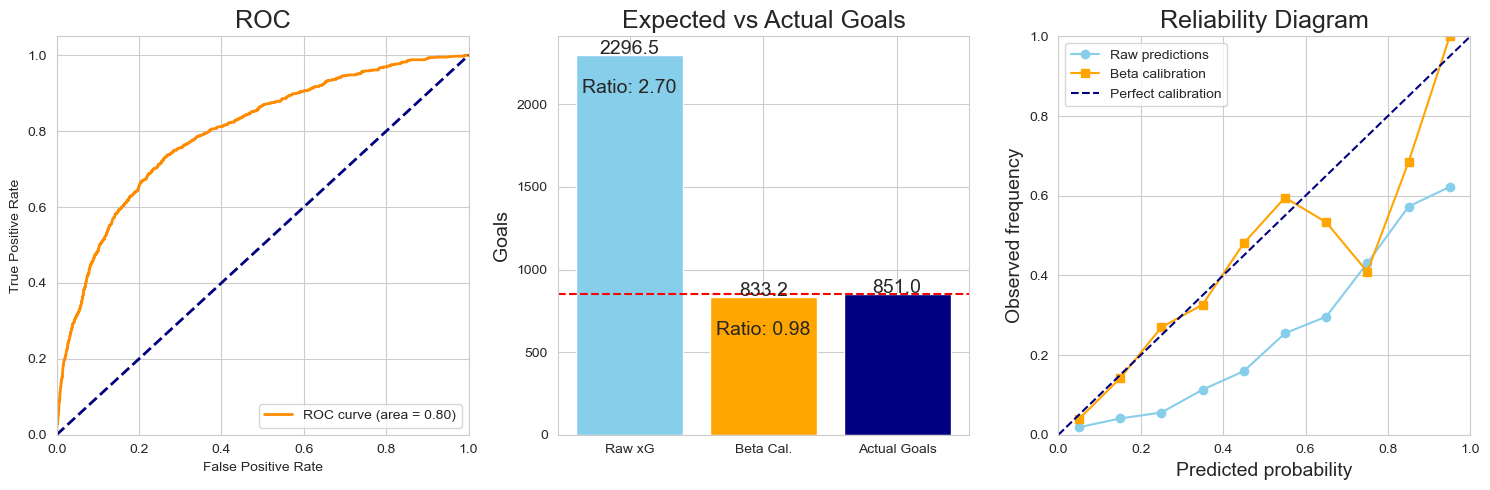

ROC AUC: 0.7975
Brier Score (Raw): 0.1076
Brier Score (Beta): 0.0729
Log Loss (Raw): 0.3589
Log Loss (Beta): 0.2568
xG/Goals Ratio: 2.6986
Beta xG/Goals Ratio: 0.9791


In [36]:
metrics_xgb = train_xgboost(X_train, y_train, X_val, y_val, X_test, y_test)

#### Parametry modelu

Najlepszy model XGBoost wykorzystuje **pełną próbę obserwacji** na każde drzewo (colsample_bytree=1.0), **niską wartość współczynnika uczenia** (learning_rate=0.1), **płytkie drzewa** o maksymalnej głębokości 3, z całkowitą liczbą estymatorów wynoszącą 100. Model wykorzystuje również **losowe próbkowanie 80% danych** (subsample=0.8) przy budowie każdego drzewa. Te hiperparametry wskazują na zrównoważone podejście zapobiegające przeuczeniu.

#### Metryki wydajności

Model osiąga wysokie **ROC AUC 0.798** i **Brier Score 0.108** przed kalibracją. Podobnie jak w przypadku innych technik modelowania, XGBoost również wykazuje problem przeszacowania prawdopodobieństw, co widać w **wysokim współczynniku xG/Goals wynoszącym 2.70**.

Po zastosowaniu kalibracji Beta:

**Brier Score** poprawia się znacząco do 0.073 (**poprawa o 32%**)
**Log Loss spada** z 0.359 do 0.257 (**poprawa o 28%**)
**Współczynnik** xG/Goals obniża się do niemal idealnego **0.98**

#### Analiza błędów

Reliability Diagram ujawnia, że surowy model znacząco **przeszacowuje prawdopodobieństwa**, szczególnie w niższych i średnich zakresach. Kalibracja Beta skutecznie koryguje te błędy, choć w średnim zakresie (0.5-0.7) **widoczne są pewne odchylenia** od idealnej kalibracji. Co istotne, dla wysokich prawdopodobieństw (>0.8) kalibracja jest **niemal idealna**.

#### Podsumowanie

Model XGBoost z kalibracją Beta stanowi **solidne narzędzie do modelowania Expected Goals**. Wykazuje dobrą zdolność do różnicowania sytuacji strzeleckich **pod względem ich jakości** (ROC AUC), a po zastosowaniu kalibracji Beta generuje **dobrze skalibrowane prawdopodobieństwa**, co potwierdza niski Brier Score i współczynnik xG/Goals bliski 1.0. Kalibracja okazuje się niezbędnym etapem przetwarzania, bez którego model znacząco przeszacowuje prawdopodobieństwa bramek.

## Podsumowanie i wnioski z projektu

### Porównanie i wybór optymalnego modelu

| Model               | ROC AUC | Brier Score | Log Loss | xG/Goals Ratio |
|---------------------|---------|-------------|----------|----------------|
| Regresja Logistyczna| 0.796   | 0.073       | 0.257    | 0.98           |
| Random Forest       | 0.796   | 0.074       | 0.259    | 0.99           |
| XGBoost             | 0.798   | 0.073       | 0.257    | 0.98           |

**XGBoost** oferuje najlepszy balans między dokładnością a kalibracją, choć przewaga jest minimalna:
- Nieznacznie wyższy ROC AUC (0.798)
- Identyczny Brier Score (0.073) i Log Loss (0.257) jak Regresja Logistyczna
- Dobrze skalibrowany współczynnik xG/Goals (0.98)

W praktyce dla wdrożenia produkcyjnego można również rozważyć **Regresję Logistyczną** ze względu na:
- Bardzo zbliżone metryki do XGBoost
- Większą interpretowalność (współczynniki modelu mają bezpośrednią interpretację)
- Niższe koszty obliczeniowe 

### Mocne strony projektu

1. **Kompleksowa inżynieria cech**:
  - Geometryczna analiza strzałów (kąt i dystans)
  - Kontekstualizacja części ciała użytej do strzału (better_foot/worse_foot)
  - Wykorzystanie freeze frames do analizy pozycji obrońców i bramkarza

2. **Efektywna kalibracja modeli**:
  - Zastosowanie Beta Calibration drastycznie poprawiło jakość predykcji
  - Redukcja błędu kalibracji z xG/Goals ~2.7 do ~0.98

3. **Metodologiczna poprawność**:
  - Jasny podział na zbiory: treningowy, walidacyjny i testowy
  - Undersampling zastosowany tylko do zbioru treningowego
  - Kalibracja na niezależnym zbiorze walidacyjnym

4. **Wizualizacja i interpretacja**:
  - Bogate wykresy pokazujące wpływ różnych czynników na skuteczność
  - Reliability diagrams ilustrujące efekt kalibracji

### Słabsze strony i ograniczenia

1. **Ograniczenia danych źródłowych**:
  - Brak informacji o prędkości piłki i innych zmiennych dynamicznych
  - Ograniczona informacja o poprzedzających sytuację wydarzeniach

2. **Problemy z imbalansem klas**:
  - Tylko ~10% strzałów kończy się golem, co wymusza resampling
  - Undersampling może prowadzić do utraty informacji, a oversampling do przeuczenia

3. **Wysoka współliniowość niektórych zmiennych**:
  - Kąt i dystans są silnie skorelowane (r = -0.75)
  - Może wpływać na stabilność modelu, szczególnie regresji logistycznej

4. **Brak oceny stabilności modelu**:
  - Dane ograniczone do jednego sezonu (2015/16) i pięciu lig (TOP5)
  - Potencjalne ryzyko przeuczenia na specyfiki konkretnej ligi/sezonu

5. **Problemy z kalibracją dla konkretnych przedziałów xG**:
  - Wszystkie modele, nawet po kalibracji, wykazują największe odchylenia dla sytuacji o xG około 0.75
  - Widoczne jest to na wykresach Reliability Diagram, gdzie linia kalibracji beta znacząco odbiega od idealnej dla tego przedziału

#### Problem kalibracji w przedziale xG ≈ 0.75

Analizując wykresy Reliability Diagram, widać wyraźnie, że dla punktu w okolicy xG ≈ 0.75 (oś X - przewidywane prawdopodobieństwo) obserwowana częstość (oś Y) wynosi około 0.4-0.5. To oznacza, że modele **przeszacowują** prawdopodobieństwo sukcesu w tym przedziale.

Innymi słowy, sytuacjom, którym model przypisuje wartość xG około 0.75 (przewidując, że 75% takich strzałów powinno zakończyć się bramką), w rzeczywistości kończą się golem tylko w około 40-50% przypadków. Jest to znaczące przeszacowanie jakości tych sytuacji.
To zjawisko może wynikać z kilku czynników:

1. **Niedostateczna reprezentacja w danych treningowych** - sytuacje o xG ≈ 0.75 są stosunkowo rzadkie, co może prowadzić do mniej stabilnych estymacji dla tego przedziału.

2. **Nadmierna ufność modelu** - modele mogą wykazywać tendencję do zbyt pewnych predykcji w przypadku sytuacji, które wydają się "oczywiste" na podstawie głównych cech (jak pozycja strzelca, brak obrońców).

3. **Nieuwzględnione czynniki utrudniające** - model może nie uwzględniać pewnych czynników, które sprawiają, że teoretycznie dobre sytuacje są w praktyce trudniejsze do wykorzystania.

4. **Problemy z generalizacją** - w tym przedziale prawdopodobieństw mogą znajdować się nietypowe sytuacje, które różnią się charakterystyką od większości danych treningowych.

### Rekomendacje na przyszłość

#### Krótkoterminowe usprawnienia:

1. **Interpretacja modeli**:
  - Dodanie analizy SHAP values do identyfikacji najważniejszych czynników
  - Porównanie ważności cech między modelami

2. **Optymalizacja podejścia do kalibracji**:
  - Przetestowanie innych metod kalibracji (Isotonic, Platt)
  - Ocena stabilności parametrów kalibracji na różnych podzbiorach danych
  - **Zastosowanie bardziej zaawansowanych technik kalibracji specyficznych dla wyższych przedziałów xG**

3. **Alternatywne techniki resamplingu**:
   - Testowanie technik SMOTE (Synthetic Minority Over-sampling Technique) zamiast prostego undersamplingu
   - Testowanie metod hybrydowych łączących over- i undersampling (np. SMOTETomek)
   - Porównanie wpływu różnych strategii resamplingu na kalibrację w problematycznych przedziałach

4. **Dodatkowa analiza sytuacji o xG ≈ 0.75**:
  - Głębsza analiza charakterystyki tych sytuacji
  - Potencjalne wyodrębnienie podkategorii sytuacji w tym przedziale

### Długoterminowe kierunki rozwoju:

1. **Rozszerzenie zbioru cech**:
  - Uwzględnienie dynamiki akcji (tempo, liczba podań w sekwencji)
  - Informacje o formie strzelca (np. skuteczność w ostatnich meczach)
  - Dane kontekstowe (wynik meczu, minuta, znaczenie spotkania)
  - **Czynniki psychologiczne/kontekstowe dla sytuacji wysokoprocentowych**

2. **Segmentacja modeli**:
  - Osobne modele dla różnych typów strzałów (np. strzały głową, rzuty wolne)
  - Uwzględnienie różnic pozycyjnych zawodników
  - **Dedykowany model dla sytuacji wysokoprocentowych (xG > 0.6)**

3. **Rozbudowa o pokrewne metryki**:
  - Expected Assists (xA)
  - Post-Shot Expected Goals (uwzględniające jakość wykonania strzału)
  - Expected Threat (xT) do oceny jakości akcji przed strzałem

4. **Walidacja cross-ligowa**:
  - Testowanie modelu na danych z różnych lig i poziomów rozgrywkowych
  - Identyfikacja potencjalnych różnic stylów gry wpływających na model

### Najważniejsze wnioski z projektu

1. **Kalibracja jest kluczowa** - wszystkie modele znacząco przeszacowywały prawdopodobieństwa goli przed kalibracją.

2. **Wybór modelu ma drugoplanowe znaczenie** - po kalibracji różnice między modelami są minimalne.

3. **Pozycjonalne informacje mają wysoką wartość** - liczba obrońców na linii strzału i obecność bramkarza są krytyczne dla jakości predykcji.

4. **Geometria sytuacji jest fundamentalna** - kąt strzału i dystans stanowią podstawę modelowania xG.

5. **Kontekst sytuacyjny wzbogaca model** - uwzględnienie czynników jak strzał z pierwszej piłki czy pod presją zwiększa dokładność.

6. **Wyzwanie kalibracyjne dla xG ≈ 0.75** - wszystkie modele, mimo dobrej globalnej kalibracji, mają trudności z dokładnym przewidywaniem dla tego specyficznego przedziału prawdopodobieństw.

Projekt stanowi solidną podstawę do dalszych badań i aplikacji w analizie piłkarskiej, oferując dobrze skalibrowany model xG, który może być wartościowym narzędziem analitycznym dla klubów, skautów i analityków sportowych.